In [ ]:
# Here is the New and Final notebook. Let's keep it neat, pretty and commentented

## Data Fetching
### MLB Stats

In [ ]:
import requests
import pandas as pd
from datetime import datetime

def get_mlb_stats(season, stat_type='hitting', limit=500):
    """
    Fetch MLB stats from the official API
    stat_type: 'hitting' or 'pitching'
    """
    base_url = "https://statsapi.mlb.com/api/v1/stats"

    # Parameters for the API call: options you are allowed to send to the API to control what data you get, API
    # determines what parameters exist
    params = {
        'stats': 'season',
        'season': season,
        'group': stat_type,
        'limit': limit,
        'sortStat': 'battingAverage' if stat_type == 'hitting' else 'earnedRunAverage',
        'order': 'desc' if stat_type == 'hitting' else 'asc'
    }

    response = requests.get(base_url, params=params)
    return response.json()

all_hitting_stats = []
for year in range(2020, 2026):
    try:
        data = get_mlb_stats(year, 'hitting')
        #JSON response returned by the MLB Stats API: nested dictionary
        # Parse the nested JSON structure
        if 'stats' in data and len(data['stats']) > 0:
            for player in data['stats'][0]['splits']:
                #accessing
                player_stats = player['stat']
                player_info = player['player']
                player_stats['player_name'] = player_info['fullName']
                player_stats['player_id'] = player_info['id']
                player_stats['season'] = year
                all_hitting_stats.append(player_stats)
    except Exception as e:
        print(f"Error fetching data for {year}: {e}")

# Convert to DataFrame
hitting_df = pd.DataFrame(all_hitting_stats)

### Salary Data

In [ ]:
import openpyxl
import pandas as pd
import requests
from io import BytesIO

def get_salary_stats(season):

  sheet_id = "12XSXOQpjDJDCJKsA4xC1e_9FlS11aeioZy_p1nqpclg"
  url = "https://docs.google.com/spreadsheets/export?exportFormat=xlsx&id=" + sheet_id
  res = requests.get(url)
  data = BytesIO(res.content)
  xlsx = openpyxl.load_workbook(filename=data)
  salary_df = pd.read_excel(data, sheet_name=f"{season}.xls")
  salary_df = salary_df.drop(columns=["Unnamed: 4",	"Unnamed: 5",	"Unnamed: 6"], axis=1)
  new_header = salary_df.iloc[0]
  salary_df = salary_df[1:]
  salary_df.columns = new_header
  salary_df = salary_df.dropna()
  salary_df['season'] = season
  salary_df = salary_df.drop(columns=["Pos'n",	"MLS"], axis=1)
  salary_df = salary_df.rename(columns={season: "salary"})
  return salary_df

salary_df = pd.DataFrame()

for year in range(2020, 2026):
    try:
        temp_salary_df = get_salary_stats(year)
        salary_df = pd.concat([salary_df, temp_salary_df])
    except Exception as e:
        print(f"Error fetching data for {year}: {e}")

### Data Cleaning

In [ ]:
# Clean the data
def convert_name_format(name):
    """
    Convert name from 'Last, First' format to 'First Last' format
    """
    # Check if comma exists
    if ',' not in name:
        return name.strip()
    # Split on first comma
    parts = name.split(',', 1)
    if len(parts) == 2:
        last_name = parts[0].strip()
        first_name = parts[1].strip()
        # Return in First Last format
        return f"{first_name} {last_name}"
    else:
        return name.strip()

def clean_player_name(name):
    """Standardize player names for matching"""
    return name.lower().strip().replace('.', '').replace(',', '')

salary_df = salary_df.rename(columns={'Player': 'player_name'})

# Add cleaned names for matching
hitting_df['clean_name'] = hitting_df['player_name'].apply(clean_player_name)
salary_df['clean_name'] = salary_df['player_name'].apply(convert_name_format).apply(clean_player_name)

salary_df.drop(columns=['player_name'], inplace=True)

# Merge on player name and year
merged_df = pd.merge(
    hitting_df,
    salary_df,
    on=['clean_name', 'season'],
    how='inner'
)

merged_df.to_csv('baseball_stats.csv')

### PCA Visualization

In [ ]:
import pandas as pd

baseball_stats_url = 'https://drive.google.com/file/d/1op6lRQHQ8FWrdyp9h85t6vBhvV8OeYeo/view?usp=sharing'
baseball_stats_url='https://drive.google.com/uc?id=' + baseball_stats_url.split('/')[-2]
baseball_stats_df = pd.read_csv(baseball_stats_url)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# use pca to reduce the numerical features
numerical_features = ['age', 'gamesPlayed', 'groundOuts', 'airOuts', 'runs',
       'doubles', 'triples', 'homeRuns', 'strikeOuts', 'baseOnBalls',
       'intentionalWalks', 'hits', 'hitByPitch', 'avg', 'atBats', 'obp', 'slg',
       'ops', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay', 'numberOfPitches',
       'plateAppearances', 'totalBases', 'rbi', 'leftOnBase', 'sacBunts',
       'sacFlies', 'babip', 'groundOutsToAirouts', 'catchersInterference']

pca = PCA(n_components=2)
pca.fit(baseball_stats_df[numerical_features])

PCA(n_components=2)

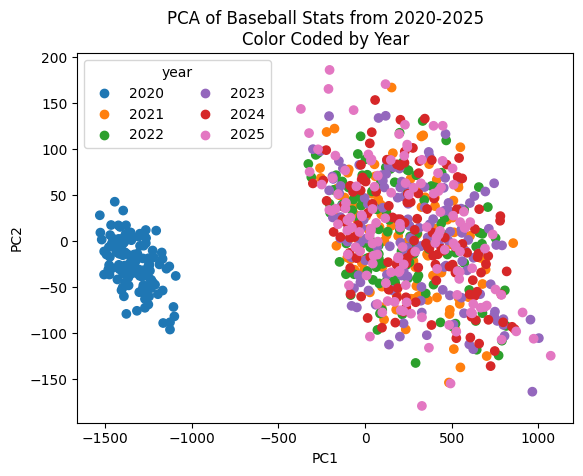

In [ ]:
import matplotlib.pyplot as plt

colors = {2020:"tab:blue", 2021:"tab:orange", 2022:"tab:green", 2023:"tab:purple", 2024:"tab:red", 2025:"tab:pink"}
plt.scatter(pca.transform(baseball_stats_df[numerical_features])[:,0], pca.transform(baseball_stats_df[numerical_features])[:,1], c=baseball_stats_df['season'].map(lambda x:colors[x]))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Baseball Stats from 2020-2025\nColor Coded by Year')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1, title="year", ncol=2)

plt.show()

In [ ]:
baseball_stats_df = baseball_stats_df[baseball_stats_df['season'] != 2020]

# use pca to reduce the numerical features and color code by salary
numerical_features = ['age', 'gamesPlayed', 'groundOuts', 'airOuts', 'runs',
       'doubles', 'triples', 'homeRuns', 'strikeOuts', 'baseOnBalls',
       'intentionalWalks', 'hits', 'hitByPitch', 'avg', 'atBats', 'obp', 'slg',
       'ops', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay', 'numberOfPitches',
       'plateAppearances', 'totalBases', 'rbi', 'leftOnBase', 'sacBunts',
       'sacFlies', 'babip', 'groundOutsToAirouts', 'catchersInterference']

pca = PCA(n_components=2)
pca.fit(baseball_stats_df[numerical_features])

import math

# add column for log salary
baseball_stats_df['log_salary'] = baseball_stats_df['salary'].map(lambda x: math.log(x))

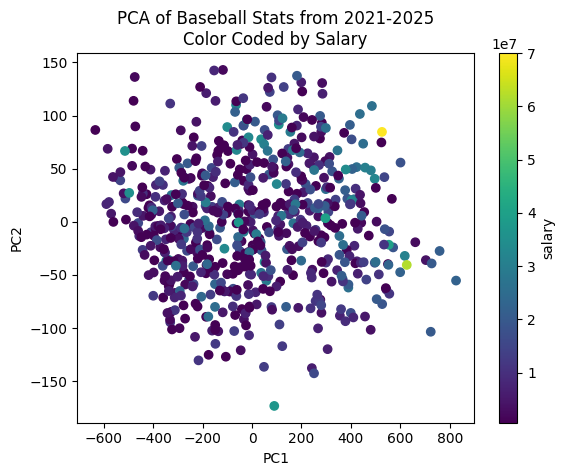

In [ ]:
import matplotlib.pyplot as plt
import math

plt.scatter(pca.transform(baseball_stats_df[numerical_features])[:,0], pca.transform(baseball_stats_df[numerical_features])[:,1], c=baseball_stats_df['salary'])
cbar = plt.colorbar()
cbar.set_label('salary')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Baseball Stats from 2021-2025\nColor Coded by Salary')
plt.show()

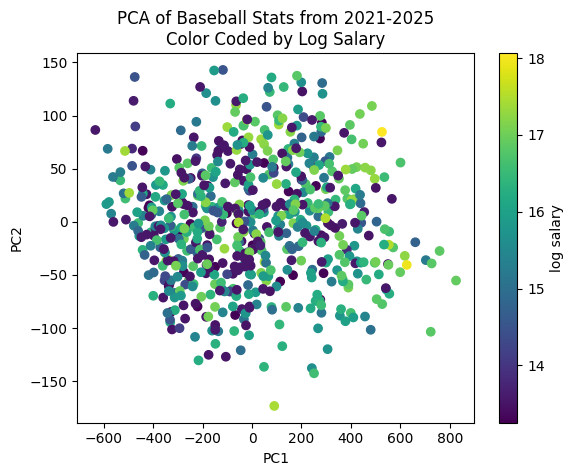

In [ ]:
import matplotlib.pyplot as plt
import math

plt.scatter(pca.transform(baseball_stats_df[numerical_features])[:,0], pca.transform(baseball_stats_df[numerical_features])[:,1], c=baseball_stats_df['log_salary'])
cbar = plt.colorbar()
cbar.set_label('log salary')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Baseball Stats from 2021-2025\nColor Coded by Log Salary')
plt.show()

### Variable Selection

We looks at variance, correlation, and Variance Inflation Factor. We drop variables that have very low variance and variables that have high correlations or high VIFs and are not considered priority variables.

In [ ]:
# Variable Selection

from sklearn.feature_selection import VarianceThreshold

# we resplit the merged data to calculate VIF with only the numeric independent  variables

vars_df = merged_df.drop(columns = "salary")
vars_df[["avg", "obp", "slg"]] = vars_df[["avg", "obp", "slg"]].astype(float)
salary_split_df = merged_df["salary"]

vars_df = vars_df.select_dtypes(include='number')

# first, we remove variables with very low variance as they will not have predictive power
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(vars_df)

# selecting prioritiy variables so that the computer drops the correct collinear variables
priority = ["avg", "rbi", "homeRuns", "slg", "obp", "age"]
corr = vars_df.corr().abs()
high_corr_pairs = []

# creates a list of highly correlated variable pairs
for p in priority:
    for v in vars_df.columns:
        if v != p and corr.loc[p, v] > 0.8:
            high_corr_pairs.append((p, v))

# drops the least important of all the highly correlated variable pairs
vars_to_drop = [
    v for (p, v) in high_corr_pairs
    if v not in priority
]

X_remainder = vars_df.drop(columns=list(set(vars_to_drop)))

# drops all non-priority collinear variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif['variable'] = X_remainder.columns
vif['VIF'] = [variance_inflation_factor(X_remainder.values, i)
                 for i in range(X_remainder.shape[1])]

vif_threshold = 10
vars_to_keep = priority + \
               list(vif.loc[vif['VIF'] < vif_threshold, 'variable'])

# Finalizing our parameters list by adding in season and player ID
vars_final = vars_to_keep
vars_final.append("season")
vars_final.append("player_id")
vars_final.remove("caughtStealing") # removed because it had a very high correlation with stolenBases (not pictured)
vars_final


['avg',
 'rbi',
 'homeRuns',
 'slg',
 'obp',
 'age',
 'triples',
 'intentionalWalks',
 'stolenBases',
 'season',
 'player_id']

In [ ]:
# Test Train Split

# adding back in our output variable
linear_df = vars_df[vars_final].copy()
linear_df["salary"] = merged_df["salary"]
linear_df["salary"] = pd.to_numeric(linear_df["salary"])

# splitting into test and train data sets based on year
train = linear_df[(linear_df["season"] >= 2021) & (linear_df["season"] <= 2024)]
test = linear_df[linear_df["season"] == 2025].copy()

y_train = train["salary"]
X_train = train.drop("salary", axis = 1)
y_test = test["salary"]
X_test = test.drop("salary", axis = 1)

### Mixed Effect Model

We looked at different methods to account for within-player correlations, but the mixed effect model produced the best and most interpretable results.

We compare the linear model versus a linear-log model (model with a linear transformation of the output variable). Based on the AIC scores, we selected the linear-log model.

In [ ]:
# linear model
import statsmodels.api as sm

md = sm.MixedLM.from_formula('salary ~ avg + rbi + homeRuns + slg + obp + triples + stolenBases + intentionalWalks + age + season', groups='player_id', data=train)
mdf = md.fit(reml=False)

# log model
log = sm.MixedLM.from_formula('np.log(salary +1) ~ avg + rbi + homeRuns + slg + obp + triples + ' \
'stolenBases + intentionalWalks + age + season', groups='player_id', data=train).fit(reml=False)
print(log.summary())

# upon comparing the linear-linear and log-linear models,
# we see that the log transformation of salary significantly improves our AIC score, so we choose that model
print("AIC (raw):", round(mdf.aic,2))
print("AIC (log):", round(log.aic,2))

# Extract Error Statistics from Trained Model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_true = log.model.endog
y_pred = log.fittedvalues
mse_log = mean_squared_error(y_true, y_pred)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_true, y_pred)

print(f"Train MSE: {round(mse_log, 3)}")
print(f"Train RMSE: {round(rmse_log, 3)}")
print(f"Train R-Squared: {round(r2_log, 3)}")

              Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: np.log(salary + 1)
No. Observations:  494     Method:             ML                
No. Groups:        240     Scale:              0.3389            
Min. group size:   1       Log-Likelihood:     -622.6491         
Max. group size:   6       Converged:          Yes               
Mean group size:   2.1                                           
-----------------------------------------------------------------
                  Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept        -303.979   63.870 -4.759 0.000 -429.161 -178.797
avg                 2.212    3.807  0.581 0.561   -5.250    9.675
rbi                -0.003    0.004 -0.711 0.477   -0.010    0.005
homeRuns            0.039    0.016  2.463 0.014    0.008    0.070
slg                -4.821    2.549 -1.892 0.059   -9.816    0.174
obp                 3.13

In [24]:
# Actual vs Predicted Graphs

train_copy = train.copy()
train_copy['log_pred'] = log.predict(train_copy)  # predicted log(salary + 1)
train_copy['log_true'] = np.log1p(train_copy['salary'])  # actual log(salary + 1)

import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(train['log_true'], train['log_pred'], alpha=0.6)
plt.plot([train['log_true'].min(), train['log_true'].max()],
         [train['log_true'].min(), train['log_true'].max()],
         color='red', linestyle='--')  # 45-degree reference line

plt.xlabel("Actual log(Salary + 1)")
plt.ylabel("Predicted log(Salary + 1)")
plt.title("Predicted vs Actual (Training Data)")
plt.show()

KeyError: 'log_true'

<Figure size 700x700 with 0 Axes>

In [ ]:
# plot test actual vs predicted graph in original units
train_copy['pred_salary'] = np.expm1(log.predict(train_copy))
train_copy['true_salary'] = train_copy['salary']

plt.figure(figsize=(8, 8))
plt.scatter(train['true_salary'], train['pred_salary'], alpha=0.6)

plt.plot([train['true_salary'].min(), train['true_salary'].max()],
         [train['true_salary'].min(), train['true_salary'].max()],
         color='red', linestyle='--')

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Predicted vs Actual Salary (Original Units)")
plt.show()

As we can see, this plot demonstrates that our model does a pretty accurate job or predicting salaries for basebally players.

There is a some vertical clumping in the left hand corner, which is mostly a result of the log-scale transformation of salary that maps the low salaries very close together. Additionally, new or low-salary players have lower random intercepts and limited predictor variation, so the model defaults to the fixed-effect average, which also compresses these data points close together.

We see below, that when we transform the values back to the original scale, this clumping dissipates, but it is also much harder to see the data points since the large value outliers distort the scale significantly.

We checked if we should transform any of our independent variables. We determined that  3 variables had significant skew. However, none of the transformations we tested improved the AIC score, so we stuck to our original log-linear model. This code was removed for concision.

### Testing on 2025 Data

Test MSE: 0.937
Test RMSE: 0.968
Test R-Squared: 0.521


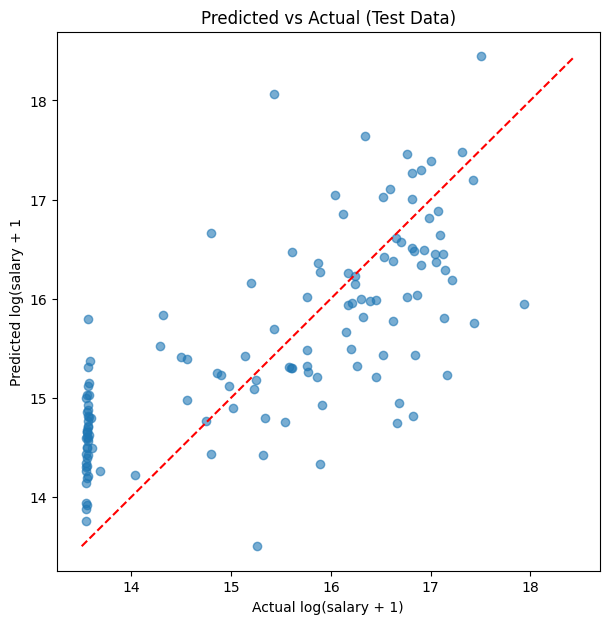

In [25]:
# predicting salaries on the test data
import numpy as np
test['log_pred'] = log.predict(test)
test['salary_pred'] = np.exp(test['log_pred'])

# extracting performance metrics from 2025 test
from sklearn.metrics import mean_squared_error, r2_score

y_true = np.log(test['salary'])
y_pred = test['log_pred']

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Test MSE: {round(mse, 3)}")
print(f"Test RMSE: {round(rmse, 3)}")
print(f"Test R-Squared: {round(r2, 3)}")

# plot predicted versus actual results
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 7))

plt.scatter(np.log(test['salary']), test['log_pred'], alpha=0.6)
plt.xlabel("Actual log(salary + 1)")
plt.ylabel("Predicted log(salary + 1")
plt.title("Predicted vs Actual (Test Data)")

lims = [
    min(np.log(test['salary']).min(), test['log_pred'].min()),
    max(np.log(test['salary']).max(), test['log_pred'].max())
]
plt.plot(lims, lims, linestyle='--', color = "red")

plt.show()


# Code for KMeans Analysis

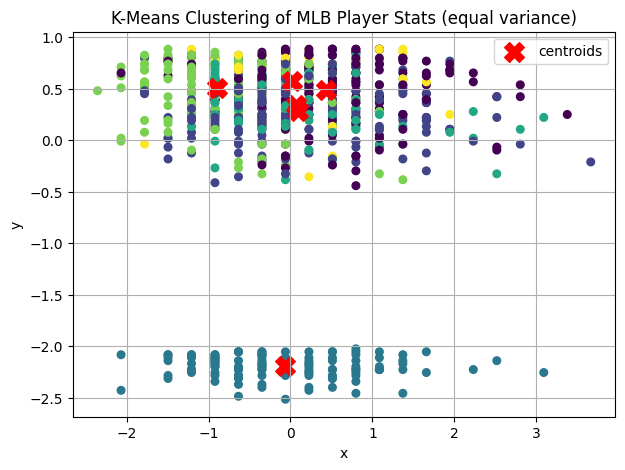

NameError: name 'inertia' is not defined

<Figure size 500x400 with 0 Axes>

In [26]:
#Prepare dataset

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd


mlb_numeric = merged_df.drop(columns=['player_name', 'player_id', 'season', 'clean_name'])

#convert salary to numeric and then log
mlb_numeric['salary'] = pd.to_numeric(mlb_numeric['salary'], errors='coerce')
mlb_numeric['log_salary'] = np.log(mlb_numeric['salary'])

for x in mlb_numeric.columns:
    mlb_numeric[x] = pd.to_numeric(mlb_numeric[x], errors='coerce')

    if mlb_numeric[x].isnull().all():
        mlb_numeric[x] = mlb_numeric[x].fillna(0) #fill entirely NAN columns with 0
    elif mlb_numeric[x].dtype in ['float64', 'int64']:
        mlb_numeric[x] = mlb_numeric[x].fillna(mlb_numeric[x].mean())

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#Standarize all variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
mlb_scaled = scaler.fit_transform(mlb_numeric)

#Initial KMeans model with 6 clusters
kmeans_model = KMeans(n_clusters=6, n_init= 100)
mlb_kmeans = kmeans_model.fit_predict(mlb_scaled) #fit the model

#Graph KMeans model
plt.figure(figsize=(7,5))


plt.scatter(mlb_scaled[:,0], mlb_scaled[:,1], c=mlb_kmeans, cmap='viridis', s=30) #color code by different k means

plt.scatter(kmeans_model.cluster_centers_[:,0], kmeans_model.cluster_centers_[:,1],
            c='red', s=200, marker='X', label='centroids')

plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering of MLB Player Stats (equal variance)')
plt.legend()
plt.grid(True)
plt.show()

#Elbow Method to find optimal number of clusters

plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("# of clusters")
plt.ylabel("Inertia (cluster compactness)")
plt.grid(True)
plt.show()

#Intertia list to show decreasing cluster compactness
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(mlb_numeric)
    inertia.append(kmeans.inertia_)

inertia

#New KMeans model with 2 clusters as determined by elbow method
kmeans_model = KMeans(n_clusters=2, n_init= 100)
mlb_kmeans = kmeans_model.fit_predict(mlb_numeric)


#Graph KMeans with 2 clusters
plt.figure(figsize=(7,5))

plt.scatter(mlb_numeric.iloc[:,0], mlb_numeric.iloc[:,1], c=mlb_kmeans, cmap='viridis', s=30) #color code by different k means

plt.scatter(kmeans_model.cluster_centers_[:,0], kmeans_model.cluster_centers_[:,1],
            c='red', s=200, marker='X', label='Centroids')

plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering of MLB Player Stats (2 clusters per elbow method)')
plt.legend()
plt.grid(True)
plt.show()


#Find Differences between the 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(mlb_numeric) #initial random centroids will be the same

mlb_numeric['cluster'] = kmeans.labels_

cluster_means = mlb_numeric.groupby('cluster').mean()

print(cluster_means)

#Reduce data with PCA

pca = PCA(n_components=0.90) #creates pca object to account for 90% of variance
top_pca = pca.fit_transform(mlb_scaled) #trains on the scaled mlb numeric data

print("pca components:", pca.n_components_) #returns # of components

#Graph with 2 clusters and PCA reduced data
kmeans_pca = KMeans(n_clusters=2, n_init=100) #Kmeans model
clusters_pca = kmeans_pca.fit_predict(top_pca) #fits and predicts clusters labels

plt.figure(figsize=(7,5))
plt.scatter(top_pca[:,0], top_pca[:,1], c=clusters_pca, cmap='viridis', s=30) #color code by different k means
plt.scatter(kmeans_pca.cluster_centers_[:,0], kmeans_pca.cluster_centers_[:,1],
            c='red', s=200, marker='X', label='Centroids')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering of MLB Player Stats with PCA')
plt.legend()
plt.grid(True)
plt.show()

#Analyze PCA components

loadings = pca.components_ #loads in principal component weights
print(loadings)

import pandas as pd

features = mlb_numeric.drop(columns=['cluster'], errors='ignore').columns #grabs columns from mlb_numeric
weight_features = pd.DataFrame(pca.components_, columns=features) #creates a df where every pca component has columns w/ the different weights of their features

weight_features

#Sort the PCA features by weight
for i in range(len(weight_features)): #for each pca
  print(f"principal component {i}:")
  print(weight_features.iloc[i].sort_values()) #least to greatest, so know what largest weights are per pca
  print("\n")

KNN Analysis:

In [28]:
# Start by importing the libraries we want to use
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
# Load dataset
df = pd.read_csv('baseball_stats.csv')

# Remove all 2020 data
stats = df[df["season"] != 2020].copy()

# Take log of salary
stats["log_salary"] = np.log(stats["salary"])


predictor_features = ['age', 'ops', 'homeRuns', 'slg', 'baseOnBalls']

train = stats[stats["season"] != 2025].copy()
test  = stats[stats["season"] == 2025].copy()

X_train = train[predictor_features]
y_train = train["log_salary"]

X_test = test[predictor_features]
y_test = test["log_salary"]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


knn = KNeighborsRegressor(n_neighbors=14)
knn.fit(X_train_scaled, y_train)


y_pred = knn.predict(X_test_scaled)

# Results
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("KNN Regression Performance (Log Salary):")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


KNN Regression Performance (Log Salary):
R² Score: 0.5661
MSE: 0.8489
RMSE: 0.9214


Scatter Plot

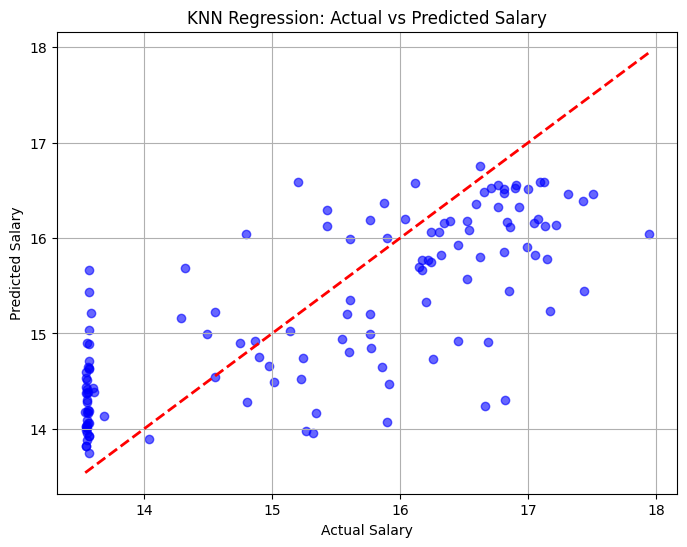

In [29]:
# Scatter plot: Actual vs Predicted Salaries
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, linestyle='--')

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("KNN Regression: Actual vs Predicted Salary")
plt.grid(True)
plt.show()


Confusion Matrix for KNN Analysis

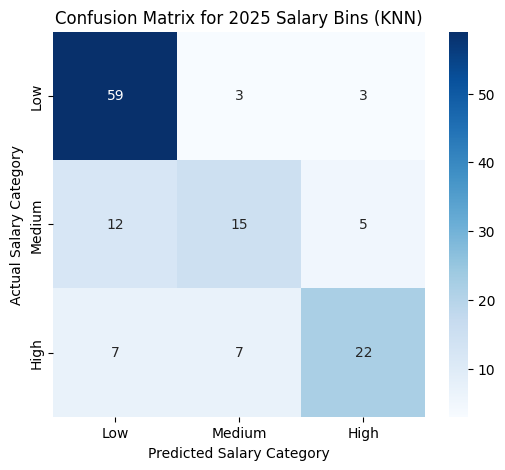

Accuracy on 2025 data:0.7218


In [33]:
# Open the dataframe
df = pd.read_csv("baseball_stats.csv")

df["log_salary"] = np.log(df["salary"])

# Create salary bins based on log salary
bins = [df["log_salary"].min(), np.log(5_000_000), np.log(15_000_000),df["log_salary"].max()]

labels = [0, 1, 2]

df["salary_category"] = pd.cut(df["log_salary"], bins=bins, labels=labels)

# remove rows with missing bins
df = df.dropna(subset=["salary_category"])

predictor_features = ["age", "ops", "homeRuns", "slg", "baseOnBalls"]

train_df = df[df["season"] != 2025]
test_df  = df[df["season"] == 2025]

X_train = train_df[predictor_features]
y_train = train_df["salary_category"]

X_test = test_df[predictor_features]
y_test = test_df["salary_category"]

# Scale predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_clf = KNeighborsClassifier(n_neighbors=20)
knn_clf.fit(X_train_scaled, y_train)

# Predict on 2025
y_pred = knn_clf.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=["Low", "Medium", "High"],
    yticklabels=["Low", "Medium", "High"]
)
plt.xlabel("Predicted Salary Category")
plt.ylabel("Actual Salary Category")
plt.title("Confusion Matrix for 2025 Salary Bins (KNN)")
plt.show()

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy on 2025 data:{acc:.4f}")


Testing K values for the best MSE

In [31]:
# Try multiple k values
k_values = range(1, 31)
mse_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    mse_scores.append(mean_squared_error(y_test, y_pred))

optimal_k = k_values[np.argmin(mse_scores)]
print("Best K for Regression:", optimal_k)

Best K for Regression: 14


## Random Forest Regression

In [ ]:
X = baseball_stats_df[numerical_features]
y = baseball_stats_df['log_salary']

X_train = X[baseball_stats_df['season'] != 2025]
y_train = y[baseball_stats_df['season'] != 2025]
X_test = X[baseball_stats_df['season'] == 2025]
y_test = y[baseball_stats_df['season'] == 2025]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

rf_regr = RandomForestRegressor(max_depth=2, random_state=0)
rf_regr.fit(X_train, y_train)

rf_regr.score(X_test, y_test)

In [ ]:
feature_importance = pd.DataFrame(rf_regr.feature_importances_, index=numerical_features, columns=['importance']).sort_values('importance', ascending=False)

plt.bar(feature_importance.index, feature_importance['importance'])
plt.xticks(rotation=90)
plt.xlabel('feature')
plt.ylabel('importance')
plt.title('Random Forest Feature Importance')
plt.show()

In [ ]:
plt.bar(feature_importance.index[:9], feature_importance['importance'][:9])
plt.xticks(rotation=90)
plt.xlabel('feature')
plt.ylabel('importance')
plt.title('Random Forest Top 9 Feature Importance')
plt.show()

In [ ]:
# plot log salary vs the top nine most important features, and show correlation coefficient
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()
for i, feature in enumerate(feature_importance.index[:9]):
    ax[i].scatter(baseball_stats_df[feature], baseball_stats_df['log_salary'])
    ax[i].set_xlabel(feature)
    if i % 3 == 0:
        ax[i].set_ylabel('log salary')
    ax[i].set_title(f'Salary vs {feature} Correlation: {baseball_stats_df[feature].corr(baseball_stats_df["log_salary"]):.2f}')
    # add line of best fit
    ax[i].plot(np.unique(baseball_stats_df[feature]), np.poly1d(np.polyfit(baseball_stats_df[feature], baseball_stats_df['log_salary'], 1))(np.unique(baseball_stats_df[feature])), color='red')
plt.tight_layout()
plt.show()

In [ ]:
# Actual vs Predicted Salaries
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, linestyle='--')
plt.xlabel("Actual Log Salary")
plt.ylabel("Predicted Log Salary")
plt.title("Random Forest Regression: Actual vs Predicted Salary")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

# compute r^2 and mse for the predictions
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("r^2: ", r_squared)
print("mse: ", mse)
print("rmse: ", rmse)